In [1]:
import os

os.environ.setdefault('TORCH_COMPILE_DISABLE', '1')
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import torch

# Method 2: Patch torch._dynamo.disable decorator after import
try:
    import torch._dynamo
    # Patch the disable function to ignore the 'wrapping' parameter
    if hasattr(torch._dynamo, 'disable'):
        def patched_disable(fn=None, *args, **kwargs):
            # Remove problematic 'wrapping' parameter if present
            if 'wrapping' in kwargs:
                kwargs.pop('wrapping')
            if fn is None:
                # Decorator usage: @disable
                return lambda f: f
            # Function usage: disable(fn) or disable(fn, **kwargs)
            # Simply return the function unwrapped to avoid recursion
            # The original disable was causing issues, so we bypass it entirely
            return fn
        torch._dynamo.disable = patched_disable
except Exception as e:
    print(f"Warning: Could not patch torch._dynamo: {e}")
    pass  # If patching fails, continue anyway

import random, string

from torchtext import data , datasets
from collections import defaultdict, Counter
import numpy as np

os.environ['GENSIM_DATA_DIR'] = os.path.join(os.getcwd(), 'gensim-data')

import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.models.fasttext import load_facebook_model

from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import time, copy
from utils import *

In [2]:
SEED = 42
train_data, validation_data, test_data, LABEL, TEXT, pretrained_embed = data_prep(SEED)

[*] Prepping Data...
[+] Test set formed!
[+] Train and Validation sets formed!
[+] Data prepped successfully!
[*] Retrieving pretrained word embeddings...
[*] Loading fasttext model...
[+] Model loaded!
[*] Forming embedding matrix...
[+] Embedding matrix formed!
[+] Embeddings retrieved successfully!

Label distribution in training set:
- ABBR: 69 samples (1.58%)
- DESC: 930 samples (21.32%)
- ENTY: 1000 samples (22.93%)
- HUM: 978 samples (22.42%)
- LOC: 668 samples (15.31%)
- NUM: 717 samples (16.44%)
Total samples: 4362, Sum of percentages: 100.00%


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Build vocabulary for labels
LABEL.build_vocab(train_data)
num_classes = len(LABEL.vocab)
print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {LABEL.vocab.itos}")

# Get pretrained embeddings from Part 1 (frozen embeddings)
# TODO: Check if this step is redundant
pretrained_embeddings = pretrained_embed.weight.data

# Get embedding dimension and vocab size from the fasttext embedding layer
embedding_dim = pretrained_embed.weight.shape[1]
embedding_vocab_size = pretrained_embed.weight.shape[0]  # Vocab size from saved embedding


Number of classes: 6
Classes: ['ENTY', 'HUM', 'DESC', 'NUM', 'LOC', 'ABBR']


In [5]:
print(f'TEXT Vocab Size: {len(TEXT.vocab.stoi)}')

TEXT Vocab Size: 8112


In [6]:
# ============================================================================
# PART 3.4: Targeted Improvement for Weak Topics
# Strategy: Data Augmentation, Positional Embeddings
# ============================================================================

print("\n" + "="*80)
print("PART 3.4: TARGETED IMPROVEMENT FOR WEAK TOPICS")
print("="*80)
print("\nStrategies:")
print("  1. Data Augmentation for imbalanced classes (especially ABBR)")
print("  2. Positional Embeddings in attention layer")
print("="*80)

# Import required libraries for augmentation
import nltk
from nltk.corpus import wordnet
try:
    nltk.download('wordnet', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
except:
    pass



PART 3.4: TARGETED IMPROVEMENT FOR WEAK TOPICS

Strategies:
  1. Data Augmentation for imbalanced classes (especially ABBR)
  2. Positional Embeddings in attention layer


In [7]:
# ============================================================================
# Step 2: Data Augmentation Functions for Imbalanced Classes
# ============================================================================

print("\n>>> Step 2: Implementing Data Augmentation Functions...")

def get_synonyms(word):
    """Get synonyms for a word using WordNet"""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ').lower()
            if synonym != word and synonym.isalpha():
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(tokens, n=1):
    """Replace n random words with their synonyms"""
    new_tokens = tokens.copy()
    words_to_replace = [i for i, word in enumerate(tokens) if word.isalpha() and len(word) > 2]
    
    if len(words_to_replace) == 0:
        return tokens
    
    num_replacements = min(n, len(words_to_replace))
    indices_to_replace = random.sample(words_to_replace, num_replacements)
    
    for idx in indices_to_replace:
        synonyms = get_synonyms(tokens[idx])
        if synonyms:
            new_tokens[idx] = random.choice(synonyms)
    
    return new_tokens

def random_insertion(tokens, n=1):
    """Randomly insert synonyms of n words"""
    new_tokens = tokens.copy()
    
    for _ in range(n):
        if len(new_tokens) == 0:
            break
        word = random.choice(new_tokens)
        synonyms = get_synonyms(word)
        if synonyms:
            synonym = random.choice(synonyms)
            insert_pos = random.randint(0, len(new_tokens))
            new_tokens.insert(insert_pos, synonym)
    
    return new_tokens

def random_deletion(tokens, p=0.1):
    """Randomly delete words with probability p"""
    if len(tokens) == 1:
        return tokens
    
    new_tokens = []
    for token in tokens:
        if random.random() > p:
            new_tokens.append(token)
    
    if len(new_tokens) == 0:
        return tokens[:1]
    
    return new_tokens

def random_swap(tokens, n=1):
    """Randomly swap n pairs of words"""
    new_tokens = tokens.copy()
    
    for _ in range(n):
        if len(new_tokens) < 2:
            break
        idx1, idx2 = random.sample(range(len(new_tokens)), 2)
        new_tokens[idx1], new_tokens[idx2] = new_tokens[idx2], new_tokens[idx1]
    
    return new_tokens

def augment_text(text, augmentation_techniques=['synonym', 'insertion', 'deletion', 'swap'], 
                 num_augmentations=3):
    """Apply data augmentation to text"""
    augmented_texts = []
    
    for _ in range(num_augmentations):
        aug_text = text.copy()
        technique = random.choice(augmentation_techniques)
        
        if technique == 'synonym' and len(aug_text) > 0:
            aug_text = synonym_replacement(aug_text, n=random.randint(1, 2))
        elif technique == 'insertion' and len(aug_text) > 0:
            aug_text = random_insertion(aug_text, n=random.randint(1, 2))
        elif technique == 'deletion' and len(aug_text) > 1:
            aug_text = random_deletion(aug_text, p=0.1)
        elif technique == 'swap' and len(aug_text) > 1:
            aug_text = random_swap(aug_text, n=1)
        
        augmented_texts.append(aug_text)
    
    return augmented_texts

print("    ✓ Data augmentation functions ready")



>>> Step 2: Implementing Data Augmentation Functions...
    ✓ Data augmentation functions ready


In [8]:

# ============================================================================
# Step 3: Apply Data Augmentation for Imbalanced Classes
# ============================================================================

print("\n>>> Step 3: Applying Data Augmentation for Imbalanced Classes...")

# Count current label distribution
label_counts_p34 = Counter([ex.label for ex in train_data.examples])
print(f"\nOriginal label distribution:")
for label, count in sorted(label_counts_p34.items()):
    print(f"  {label}: {count} samples ({count/len(train_data.examples)*100:.2f}%)")

# Target counts: Augment ABBR significantly, keep others similar
target_counts_p34 = {
    'ABBR': 500,   # Augment from 69 to 500 (~7x)
    'DESC': 930,   # Keep original
    'ENTY': 1000,  # Keep original
    'HUM': 978,    # Keep original
    'LOC': 668,    # Keep original
    'NUM': 717     # Keep original
}

# Create augmented examples
augmented_examples = list(train_data.examples)  # Start with all original examples

for label in label_counts_p34.keys():
    current_count = label_counts_p34[label]
    target_count = target_counts_p34[label]
    
    if current_count < target_count:
        label_examples = [ex for ex in train_data.examples if ex.label == label]
        num_augmentations_needed = target_count - current_count
        
        print(f"\n  Augmenting {label}: {current_count} -> {target_count} samples")
        print(f"    Generating {num_augmentations_needed} additional samples...")
        
        augmented_count = 0
        while augmented_count < num_augmentations_needed:
            original_ex = random.choice(label_examples)
            aug_texts = augment_text(original_ex.text, num_augmentations=1)
            
            for aug_text in aug_texts:
                if augmented_count >= num_augmentations_needed:
                    break
                
                new_ex = data.Example.fromlist([aug_text, label], 
                                               fields=[('text', TEXT), ('label', LABEL)])
                augmented_examples.append(new_ex)
                augmented_count += 1
        
        print(f"    ✓ Generated {augmented_count} augmented samples")

# Create augmented dataset with proper field structure
augmented_train_data = data.Dataset(augmented_examples, fields=[('text', TEXT), ('label', LABEL)])

# Verify augmented distribution
new_label_counts = Counter([ex.label for ex in augmented_examples])
print(f"\nAugmented label distribution:")
for label, count in sorted(new_label_counts.items()):
    print(f"  {label}: {count} samples ({count/len(augmented_examples)*100:.2f}%)")

print(f"\n  Total samples: {len(train_data.examples)} -> {len(augmented_examples)}")
print(f"  ✓ Data augmentation complete")


>>> Step 3: Applying Data Augmentation for Imbalanced Classes...

Original label distribution:
  ABBR: 69 samples (1.58%)
  DESC: 930 samples (21.32%)
  ENTY: 1000 samples (22.93%)
  HUM: 978 samples (22.42%)
  LOC: 668 samples (15.31%)
  NUM: 717 samples (16.44%)

  Augmenting ABBR: 69 -> 500 samples
    Generating 431 additional samples...
    ✓ Generated 431 augmented samples

Augmented label distribution:
  ABBR: 500 samples (10.43%)
  DESC: 930 samples (19.40%)
  ENTY: 1000 samples (20.86%)
  HUM: 978 samples (20.40%)
  LOC: 668 samples (13.94%)
  NUM: 717 samples (14.96%)

  Total samples: 4362 -> 4793
  ✓ Data augmentation complete


In [9]:
# augmented_train_data.examples[0].label
[(ex.text, ex.label) for ex in augmented_train_data if ex.label not in ['ABBR','DESC','ENTY','HUM','LOC','NUM']]

[]

In [10]:
LABEL.vocab.stoi

defaultdict(None,
            {'ENTY': 0, 'HUM': 1, 'DESC': 2, 'NUM': 3, 'LOC': 4, 'ABBR': 5})

In [11]:
abbr_aug_ex = [ex for ex in augmented_train_data if ex.label == "ABBR"]
abbr_ex = [ex for ex in train_data if ex.label == "ABBR"]

count = 0
for ex in abbr_aug_ex:
    if ex not in abbr_ex:
        print(ex.text)
        print(ex.label)
        count += 1

print(count)

['What', "'s", 'the', 'abbreviation', 'for', 'limited', 'partnership', '?']
ABBR
['What', 'does', 'the', 'E', 'stand', 'for', 'in', 'the', 'equation', 'E', '=', 'mc2', '?']
ABBR
['What', 'is', 'LMDS', '?']
ABBR
['What', 'is', 'DTMF', '?', 'live']
ABBR
['What', 'does', 'R.E.M.', 'stand', 'for', ',', 'as', 'in', 'the', 'rock', 'group', 'R.E.M.', 'stone', '?']
ABBR
['What', 'is', 'the', 'manakin', 'full', 'form', 'of', '.com', '?']
ABBR
['CNN', 'is', 'an', 'acronym', 'for', 'what', '?']
ABBR
['What', "'s", 'the', 'abbreviation', 'for', 'trinitrotoluene', '?']
ABBR
['What', 'does', 'stand', 'for']
ABBR
['What', 'does', 'harbor', 'brook', 'for', '?']
ABBR
['What', 'is', 'RCD', '?']
ABBR
['What', 'is', 'BPH', '?']
ABBR
['What', 'is', 'a', '`', '`', 'USB', "''", 'on', 'a', 'computer', '?']
ABBR
['What', 'is', 'p.m.', 'an', 'abbreviation', 'for', ',', 'as', 'in', '5', 'p.m.', '?']
ABBR
['What', 'is', 'SAP', '?', 'follow', 'surveil']
ABBR
['LMDS', 'is', 'What', '?']
ABBR
['does', 'What', 'the',

In [12]:
# Count how many samples per label in the train set
label_counts_p34 = Counter([ex.label for ex in augmented_train_data.examples])
total_examples_p34 = len(augmented_train_data)

print("\nLabel distribution in training set:")
for label, count in sorted(label_counts_p34.items()):
    percentage = (count / total_examples_p34) * 100
    print(f"- {label}: {count} samples ({percentage:.2f}%)")


Label distribution in training set:
- ABBR: 500 samples (10.43%)
- DESC: 930 samples (19.40%)
- ENTY: 1000 samples (20.86%)
- HUM: 978 samples (20.40%)
- LOC: 668 samples (13.94%)
- NUM: 717 samples (14.96%)


In [13]:
# ============================================================================
# Step 5: RNN Model with Positional Embeddings in Attention Layer
# ============================================================================

print("\n>>> Step 5: Creating RNN Model with Positional Embeddings...")

class RNNWithPositionalAttentionClassifier(nn.Module):
    """
    RNN with Attention and Positional Embeddings
    Adds positional information to help the model understand word order
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=2, dropout=0.5, padding_idx=0, pretrained_embeddings=None,
                 attention_dim=None, max_seq_length=100, use_positional_emb=True):
        super(RNNWithPositionalAttentionClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.attention_dim = attention_dim if attention_dim else hidden_dim
        self.embedding_dim = embedding_dim
        self.max_seq_length = max_seq_length
        self.use_positional_emb = use_positional_emb
        
        # Word Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            self.embedding.weight.requires_grad = True
        
        # Positional Embedding layer (learnable)
        if self.use_positional_emb:
            self.positional_embedding = nn.Embedding(max_seq_length, embedding_dim)
            # Initialize with sinusoidal pattern
            self._init_positional_embeddings()
        
        # Bidirectional LSTM layer
        self.rnn = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Attention Mechanism with positional awareness
        self.attention_linear1 = nn.Linear(hidden_dim * 2, self.attention_dim)
        self.attention_linear2 = nn.Linear(self.attention_dim, 1)
        self.tanh = nn.Tanh()
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def _init_positional_embeddings(self):
        """Initialize positional embeddings with sinusoidal pattern"""
        pe = torch.zeros(self.max_seq_length, self.embedding_dim)
        position = torch.arange(0, self.max_seq_length).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, self.embedding_dim, 2).float() * 
                            -(np.log(10000.0) / self.embedding_dim))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Set as parameter data (no gradient for positional embeddings initially, but can be learned)
        with torch.no_grad():
            self.positional_embedding.weight.data = pe
    
    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len]
        batch_size, seq_len = text.size()
        
        # Word Embeddings
        word_embeddings = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        
        # Positional Embeddings
        if self.use_positional_emb:
            positions = torch.arange(0, seq_len, device=text.device).unsqueeze(0).expand(batch_size, -1)
            positions = torch.clamp(positions, 0, self.max_seq_length - 1)
            pos_embeddings = self.positional_embedding(positions)  # [batch_size, seq_len, embedding_dim]
            
            # Combine word and positional embeddings
            embedded = word_embeddings + pos_embeddings
        else:
            embedded = word_embeddings
        
        # Pack sequences for efficient RNN processing
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # Pass through bidirectional LSTM
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        # Unpack the sequences
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True
        )
        # output: [batch_size, seq_len, hidden_dim * 2]
        
        # Apply Attention Mechanism with positional information
        attention_scores = self.attention_linear1(output)  # [batch_size, seq_len, attention_dim]
        attention_scores = self.tanh(attention_scores)
        attention_scores = self.attention_linear2(attention_scores).squeeze(2)  # [batch_size, seq_len]
        
        # Mask padding positions
        mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths.unsqueeze(1)
        attention_scores = attention_scores.masked_fill(~mask, float('-inf'))
        
        # Apply softmax to get attention weights
        attention_weights = torch.softmax(attention_scores, dim=1).unsqueeze(2)  # [batch_size, seq_len, 1]
        
        # Compute weighted sum of RNN outputs
        context_vector = torch.sum(attention_weights * output, dim=1)  # [batch_size, hidden_dim * 2]
        
        # Apply dropout
        context_vector = self.dropout(context_vector)
        
        # Pass through fully connected layer
        output = self.fc(context_vector)  # [batch_size, output_dim]
        
        return output

print("    ✓ RNNWithPositionalAttentionClassifier model created")
print("    Features:")
print("      - Word embeddings (FastText pretrained)")
print("      - Positional embeddings (sinusoidal pattern)")
print("      - Bidirectional LSTM")
print("      - Attention mechanism with positional awareness")



>>> Step 5: Creating RNN Model with Positional Embeddings...
    ✓ RNNWithPositionalAttentionClassifier model created
    Features:
      - Word embeddings (FastText pretrained)
      - Positional embeddings (sinusoidal pattern)
      - Bidirectional LSTM
      - Attention mechanism with positional awareness


In [ ]:
# ============================================================================
# Step 6.2: Create Iterators (augmented dataset)
# ============================================================================

print("\n>>> Step 6: Creating Iterators...")

P34_BATCH_SIZE = 32


train_iter_p34_norm = data.BucketIterator(
    train_data,
    batch_size=P34_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

# Create iterators
train_iter_p34 = data.BucketIterator(
    augmented_train_data,
    batch_size=P34_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

# Validation and test iterators
val_iter_p34 = data.BucketIterator(
    validation_data,
    batch_size=P34_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

test_iter_p34 = data.BucketIterator(
    test_data,
    batch_size=P34_BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

print(f"    ✓ Training Augmented iterator: {len(augmented_train_data)} samples")
print(f"    ✓ Training Normal iterator: {len(train_data)} samples")
print(f"    ✓ Validation iterator: {len(validation_data)} samples")
print(f"    ✓ Test iterator: {len(test_data)} samples")
print(f"    ✓ Batch size: {P34_BATCH_SIZE}")


>>> Step 6: Creating Iterators...
    ✓ Training Augmented iterator: 4793 samples
    ✓ Training Normal iterator: 4362 samples
    ✓ Validation iterator: 1090 samples
    ✓ Test iterator: 500 samples
    ✓ Batch size: 32


In [ ]:
# ============================================================================
# Step 7: Train Part 3.4 Model
# ============================================================================

print("\n>>> Step 7: Training Part 3.4 Normal + Positional True, Enhanced Model...")

# Model hyperparameters
P34_EMBEDDING_DIM = embedding_dim
P34_HIDDEN_DIM = 128
P34_N_LAYERS = 2
P34_DROPOUT = 0.7
P34_ATTENTION_DIM = 256
P34_MAX_SEQ_LENGTH = 100
P34_LEARNING_RATE = 0.0001
P34_N_EPOCHS = 100
P34_PATIENCE = 10
P34_BATCH_SIZE = 32
P34_NUM_CLASSES = len(LABEL.vocab)

# Create model
p34_model = RNNWithPositionalAttentionClassifier(
    vocab_size=len(TEXT.vocab),
    embedding_dim=P34_EMBEDDING_DIM,
    hidden_dim=P34_HIDDEN_DIM,
    output_dim=P34_NUM_CLASSES,
    n_layers=P34_N_LAYERS,
    dropout=P34_DROPOUT,
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings,
    attention_dim=P34_ATTENTION_DIM,
    max_seq_length=P34_MAX_SEQ_LENGTH,
    use_positional_emb=True
).to(device)

# Loss function and optimizer
p34_criterion = nn.CrossEntropyLoss()
p34_optimizer = optim.Adam(p34_model.parameters(), lr=P34_LEARNING_RATE)


# Train the model
print("\n>>> Starting training...")
p34_model.train()
best_val_acc = 0.0
best_val_f1 = 0.0
best_val_auc = 0.0
patience_counter = 0
best_model_state = None

print(f"\n>>> Part 3.4  Normal + Positional True Model Configuration:")
print(f"    Embedding Dim: {P34_EMBEDDING_DIM}")
print(f"    Hidden Dim: {P34_HIDDEN_DIM}")
print(f"    Layers: {P34_N_LAYERS}")
print(f"    Dropout: {P34_DROPOUT}")
print(f"    Attention Dim: {P34_ATTENTION_DIM}")
print(f"    Learning Rate: {P34_LEARNING_RATE}")
print(f"    Batch Size: {P34_BATCH_SIZE}")
print(f"    Max Epochs: {P34_N_EPOCHS}, Patience: {P34_PATIENCE}")
print(f"    Max Seq Length: {P34_MAX_SEQ_LENGTH}")
print(f"    Positional Embeddings: Enabled")
print(f"    Parameters: {sum(p.numel() for p in p34_model.parameters()):,}")

# Train RNN + Attention model
p34_model, p34_history = train_model_with_history(
    p34_model, train_iter_p34_norm, val_iter_p34, p34_optimizer, p34_criterion,
    P34_N_EPOCHS, device, num_classes, patience=P34_PATIENCE, model_name="RNN+PositionAttention (Normal + Positional True)"
)


# Load best model state
if best_model_state is not None:
    p34_model.load_state_dict(best_model_state)

# Save model
torch.save(p34_model.state_dict(), 'weights/part34_enhanced_best_normal_positional_true.pt')
print(f"\n>>> Part 3.4 model saved to 'weights/part34_enhanced_best_normal_positional_true.pt'")



>>> Step 7: Training Part 3.4 Normal + Positional True, Enhanced Model...

>>> Starting training...

>>> Part 3.4  Normal + Positional True Model Configuration:
    Embedding Dim: 300
    Hidden Dim: 128
    Layers: 2
    Dropout: 0.7
    Attention Dim: 256
    Learning Rate: 0.0001
    Batch Size: 32
    Max Epochs: 100, Patience: 10
    Max Seq Length: 100
    Positional Embeddings: Enabled
    Parameters: 3,370,675

>>> Training RNN+PositionAttention (Normal + Positional True)
    Parameters: 3,370,675
    Max epochs: 100, Patience: 10
Epoch: 01/100 | Time: 0m 3s
	Train Loss: 1.6941 | Train Acc: 24.23%
	Val Loss: 1.6334 | Val Acc: 24.86% | Val F1: 0.1216 | Val AUC: 0.5829
Epoch: 02/100 | Time: 0m 3s
	Train Loss: 1.6513 | Train Acc: 25.97%
	Val Loss: 1.6099 | Val Acc: 29.45% | Val F1: 0.2355 | Val AUC: 0.5972
Epoch: 03/100 | Time: 0m 3s
	Train Loss: 1.6317 | Train Acc: 28.79%
	Val Loss: 1.5964 | Val Acc: 28.81% | Val F1: 0.2322 | Val AUC: 0.6081
Epoch: 04/100 | Time: 0m 3s
	Train Lo

In [ ]:
# ============================================================================
# Step 8: Evaluate Part 3.4 Model on Test Set
# ============================================================================

print("\n>>> Step 8: Evaluating Part 3.4 Normal + Positional True on Test Set...")

# Evaluate RNN + Attention
print("\n>>> Evaluating RNN + Positional + Attention + Augmented on test set...")
p34_test_loss, p34_test_acc, p34_test_f1, p34_test_auc = evaluate_model(
    p34_model, test_iter_p34, p34_criterion, device, "RNN+PositionAttention (Normal + Positional True)", num_classes
)

print(f"\n>>> RNN + Positional + Attention + Normal + Positional True Test Set Results:")
print(f"    Test Loss: {p34_test_loss:.4f}")
print(f"    Test Accuracy: {p34_test_acc*100:.2f}%")
print(f"    Test F1 Score: {p34_test_f1:.4f}")
print(f"    Test AUC-ROC: {p34_test_auc:.4f}")


>>> Step 8: Evaluating Part 3.4 Normal + Positional True on Test Set...

>>> Evaluating RNN + Positional + Attention + Augmented on test set...

>>> RNN + Positional + Attention + Normal Test Set Results:
    Test Loss: 0.6808
    Test Accuracy: 81.20%
    Test F1 Score: 0.8284
    Test AUC-ROC: 0.9627


In [ ]:
# ============================================================================
# Step 7: Train Part 3.4 Model
# ============================================================================

print("\n>>> Step 7: Training Part 3.4 Augmented + Positional False, Enhanced Model...")

# Model hyperparameters
P34_EMBEDDING_DIM = embedding_dim
P34_HIDDEN_DIM = 128
P34_N_LAYERS = 2
P34_DROPOUT = 0.7
P34_ATTENTION_DIM = 256
P34_MAX_SEQ_LENGTH = 100
P34_LEARNING_RATE = 0.0001
P34_N_EPOCHS = 100
P34_PATIENCE = 10
P34_BATCH_SIZE = 32
P34_NUM_CLASSES = len(LABEL.vocab)

# Create model
p34_model = RNNWithPositionalAttentionClassifier(
    vocab_size=len(TEXT.vocab),
    embedding_dim=P34_EMBEDDING_DIM,
    hidden_dim=P34_HIDDEN_DIM,
    output_dim=P34_NUM_CLASSES,
    n_layers=P34_N_LAYERS,
    dropout=P34_DROPOUT,
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings,
    attention_dim=P34_ATTENTION_DIM,
    max_seq_length=P34_MAX_SEQ_LENGTH,
    use_positional_emb=False
).to(device)

# Loss function and optimizer
p34_criterion = nn.CrossEntropyLoss()
p34_optimizer = optim.Adam(p34_model.parameters(), lr=P34_LEARNING_RATE)


# Train the model
print("\n>>> Starting training...")
p34_model.train()
best_val_acc = 0.0
best_val_f1 = 0.0
best_val_auc = 0.0
patience_counter = 0
best_model_state = None

print(f"\n>>> Part 3.4 Augmented + Positional False Model Configuration:")
print(f"    Embedding Dim: {P34_EMBEDDING_DIM}")
print(f"    Hidden Dim: {P34_HIDDEN_DIM}")
print(f"    Layers: {P34_N_LAYERS}")
print(f"    Dropout: {P34_DROPOUT}")
print(f"    Attention Dim: {P34_ATTENTION_DIM}")
print(f"    Learning Rate: {P34_LEARNING_RATE}")
print(f"    Batch Size: {P34_BATCH_SIZE}")
print(f"    Max Epochs: {P34_N_EPOCHS}, Patience: {P34_PATIENCE}")
print(f"    Max Seq Length: {P34_MAX_SEQ_LENGTH}")
print(f"    Positional Embeddings: Enabled")
print(f"    Parameters: {sum(p.numel() for p in p34_model.parameters()):,}")

# Train RNN + Attention model
p34_model, p34_history = train_model_with_history(
    p34_model, train_iter_p34, val_iter_p34, p34_optimizer, p34_criterion,
    P34_N_EPOCHS, device, num_classes, patience=P34_PATIENCE, model_name="RNN+PositionAttention (Augmented + Positional False)"
)


# Load best model state
if best_model_state is not None:
    p34_model.load_state_dict(best_model_state)

# Save model
torch.save(p34_model.state_dict(), 'weights/part34_enhanced_best_augmented_positional_false.pt')
print(f"\n>>> Part 3.4 model saved to 'weights/part34_enhanced_best_augmented_positional_false.pt'")


>>> Step 7: Training Part 3.4 Augmented + Positional False, Enhanced Model...

>>> Starting training...

>>> Part 3.4 Augmented + Positional False Model Configuration:
    Embedding Dim: 300
    Hidden Dim: 128
    Layers: 2
    Dropout: 0.7
    Attention Dim: 256
    Learning Rate: 0.0001
    Batch Size: 32
    Max Epochs: 100, Patience: 10
    Max Seq Length: 100
    Positional Embeddings: Enabled
    Parameters: 3,340,675

>>> Training RNN+PositionAttention (Augmented + Positional False)
    Parameters: 3,340,675
    Max epochs: 100, Patience: 10
Epoch: 01/100 | Time: 0m 3s
	Train Loss: 1.7756 | Train Acc: 20.49%
	Val Loss: 1.7189 | Val Acc: 24.68% | Val F1: 0.1194 | Val AUC: 0.5899
Epoch: 02/100 | Time: 0m 3s
	Train Loss: 1.7114 | Train Acc: 24.01%
	Val Loss: 1.5705 | Val Acc: 41.10% | Val F1: 0.3330 | Val AUC: 0.7141
Epoch: 03/100 | Time: 0m 3s
	Train Loss: 1.4507 | Train Acc: 42.19%
	Val Loss: 1.2962 | Val Acc: 47.06% | Val F1: 0.4271 | Val AUC: 0.7911
Epoch: 04/100 | Time: 0m 3

In [ ]:
# ============================================================================
# Step 8: Evaluate Part 3.4 Model on Test Set
# ============================================================================

print("\n>>> Step 8: Evaluating Part 3.4 Augmented + Positional False Model on Test Set...")

# Evaluate RNN + Attention
print("\n>>> Evaluating RNN + Positional + Attention + Augmented on test set...")
p34_test_loss, p34_test_acc, p34_test_f1, p34_test_auc = evaluate_model(
    p34_model, test_iter_p34, p34_criterion, device, "RNN+PositionAttention (Augmented + Positional False)", num_classes
)

print(f"\n>>> RNN + Positional + Attention + Augmented + Postitional False Test Set Results:")
print(f"    Test Loss: {p34_test_loss:.4f}")
print(f"    Test Accuracy: {p34_test_acc*100:.2f}%")
print(f"    Test F1 Score: {p34_test_f1:.4f}")
print(f"    Test AUC-ROC: {p34_test_auc:.4f}")


>>> Step 8: Evaluating Part 3.4 Augmented + Positional False Model on Test Set...

>>> Evaluating RNN + Positional + Attention + Augmented on test set...

>>> RNN + Positional + Attention + Augmented + Postitional False Test Set Results:
    Test Loss: 3.4923
    Test Accuracy: 42.20%
    Test F1 Score: 0.4857
    Test AUC-ROC: 0.7303


In [ ]:
# ============================================================================
# Step 7: Train Part 3.4 Model
# ============================================================================

print("\n>>> Step 7: Training Part 3.4 Augmented + Positional True, Enhanced Model...")

# Model hyperparameters
P34_EMBEDDING_DIM = embedding_dim
P34_HIDDEN_DIM = 128
P34_N_LAYERS = 2
P34_DROPOUT = 0.7
P34_ATTENTION_DIM = 256
P34_MAX_SEQ_LENGTH = 100
P34_LEARNING_RATE = 0.0001
P34_N_EPOCHS = 100
P34_PATIENCE = 10
P34_BATCH_SIZE = 32
P34_NUM_CLASSES = len(LABEL.vocab)

# Create model
p34_model_augmented_positional_true = RNNWithPositionalAttentionClassifier(
    vocab_size=len(TEXT.vocab),
    embedding_dim=P34_EMBEDDING_DIM,
    hidden_dim=P34_HIDDEN_DIM,
    output_dim=P34_NUM_CLASSES,
    n_layers=P34_N_LAYERS,
    dropout=P34_DROPOUT,
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings,
    attention_dim=P34_ATTENTION_DIM,
    max_seq_length=P34_MAX_SEQ_LENGTH,
    use_positional_emb=True
).to(device)

# Loss function and optimizer
p34_criterion = nn.CrossEntropyLoss()
p34_optimizer = optim.Adam(p34_model_augmented_positional_true.parameters(), lr=P34_LEARNING_RATE)


# Train the model
print("\n>>> Starting training...")
p34_model_augmented_positional_true.train()
best_val_acc = 0.0
best_val_f1 = 0.0
best_val_auc = 0.0
patience_counter = 0
best_model_state = None

print(f"\n>>> Part 3.4 Augmented + Positional True Model Configuration:")
print(f"    Embedding Dim: {P34_EMBEDDING_DIM}")
print(f"    Hidden Dim: {P34_HIDDEN_DIM}")
print(f"    Layers: {P34_N_LAYERS}")
print(f"    Dropout: {P34_DROPOUT}")
print(f"    Attention Dim: {P34_ATTENTION_DIM}")
print(f"    Learning Rate: {P34_LEARNING_RATE}")
print(f"    Batch Size: {P34_BATCH_SIZE}")
print(f"    Max Epochs: {P34_N_EPOCHS}, Patience: {P34_PATIENCE}")
print(f"    Max Seq Length: {P34_MAX_SEQ_LENGTH}")
print(f"    Positional Embeddings: Enabled")
print(f"    Parameters: {sum(p.numel() for p in p34_model.parameters()):,}")

# Train RNN + Attention model
p34_model_augmented_positional_true, p34_history = train_model_with_history(
    p34_model_augmented_positional_true, train_iter_p34, val_iter_p34, p34_optimizer, p34_criterion,
    P34_N_EPOCHS, device, num_classes, patience=P34_PATIENCE, model_name="RNN+PositionAttention (Augmented + Positional True)"
)

# Load best model state
if best_model_state is not None:
    p34_model_augmented_positional_true.load_state_dict(best_model_state)

# Save model
torch.save(p34_model_augmented_positional_true.state_dict(), 'weights/part34_enhanced_best_augmented_positional_true.pt')
print(f"\n>>> Part 3.4 model saved to 'weights/part34_enhanced_best_augmented_positional_true.pt'")


>>> Step 7: Training Part 3.4 Augmented + Positional True, Enhanced Model...

>>> Starting training...

>>> Part 3.4 Augmented + Positional True Model Configuration:
    Embedding Dim: 300
    Hidden Dim: 128
    Layers: 2
    Dropout: 0.7
    Attention Dim: 256
    Learning Rate: 0.0001
    Batch Size: 32
    Max Epochs: 100, Patience: 10
    Max Seq Length: 100
    Positional Embeddings: Enabled
    Parameters: 3,340,675

>>> Training RNN+PositionAttention (Augmented + Positional True)
    Parameters: 3,370,675
    Max epochs: 100, Patience: 10
Epoch: 01/100 | Time: 0m 4s
	Train Loss: 1.7560 | Train Acc: 21.72%
	Val Loss: 1.6820 | Val Acc: 27.71% | Val F1: 0.2017 | Val AUC: 0.5930
Epoch: 02/100 | Time: 0m 3s
	Train Loss: 1.7209 | Train Acc: 25.41%
	Val Loss: 1.6473 | Val Acc: 27.61% | Val F1: 0.2196 | Val AUC: 0.5932
Epoch: 03/100 | Time: 0m 3s
	Train Loss: 1.6974 | Train Acc: 25.87%
	Val Loss: 1.6476 | Val Acc: 28.99% | Val F1: 0.2262 | Val AUC: 0.6055
Epoch: 04/100 | Time: 0m 3s
	

In [ ]:
# ============================================================================
# Step 8: Evaluate Part 3.4 Model on Test Set
# ============================================================================

print("\n>>> Step 8: Evaluating Part 3.4 Augmented + Positional True Model on Test Set...")

# Evaluate RNN + Attention
print("\n>>> Evaluating RNN + Positional + Attention + Augmented on test set...")
p34_test_loss, p34_test_acc, p34_test_f1, p34_test_auc = evaluate_model(
    p34_model_augmented_positional_true, test_iter_p34, p34_criterion, device, "RNN+PositionAttention (Augmented + Positional True)", num_classes
)

print(f"\n>>> RNN + Positional + Attention + Augmented + Postitional True Test Set Results:")
print(f"    Test Loss: {p34_test_loss:.4f}")
print(f"    Test Accuracy: {p34_test_acc*100:.2f}%")
print(f"    Test F1 Score: {p34_test_f1:.4f}")
print(f"    Test AUC-ROC: {p34_test_auc:.4f}")


>>> Step 8: Evaluating Part 3.4 Augmented + Positional True Model on Test Set...

>>> Evaluating RNN + Positional + Attention + Augmented on test set...

>>> RNN + Positional + Attention + Augmented + Postitional True Test Set Results:
    Test Loss: 3.1898
    Test Accuracy: 38.20%
    Test F1 Score: 0.4535
    Test AUC-ROC: 0.7288


In [ ]:
# ============================================================================
# Step 9: Topic-wise Accuracy Evaluation and Comparison
# ============================================================================

print("\n>>> Step 9: Topic-wise Accuracy Evaluation...")

def evaluate_per_topic_p34(model, iterator, device):
    """Evaluate model performance per topic category"""
    model.eval()
    
    topic_correct = defaultdict(int)
    topic_total = defaultdict(int)
    
    idx_to_label = LABEL.vocab.itos
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths, labels = process_batch(batch)
            predictions = model(text, text_lengths)
            preds = torch.argmax(predictions, dim=1)
            
            for pred, label in zip(preds.cpu().numpy(), labels.cpu().numpy()):
                topic_name = idx_to_label[label]
                topic_total[topic_name] += 1
                if pred == label:
                    topic_correct[topic_name] += 1
    
    # Calculate accuracy per topic
    topic_accuracies = {}
    for topic in sorted(topic_total.keys()):
        acc = topic_correct[topic] / topic_total[topic] if topic_total[topic] > 0 else 0
        topic_accuracies[topic] = acc
        print(f'  {topic}: {topic_correct[topic]}/{topic_total[topic]} = {acc*100:.2f}%')
    
    return topic_accuracies

print("\n>>> Part 3.4 Enhanced Model - Topic-wise Accuracy:")
p34_topic_acc = evaluate_per_topic_p34(p34_model, test_iter_p34, device)

# Note: To compare with Part 2(e), you would need to load and evaluate the baseline model
# For now, we'll display Part 3.4 results
print("\n" + "="*80)
print("PART 3.4 TOPIC-WISE ACCURACY SUMMARY")
print("="*80)
print(f"{'Topic':<10} {'Accuracy':<12} {'Correct':<10} {'Total':<10}")
print("-" * 50)
for topic in sorted(p34_topic_acc.keys()):
    # Get counts from evaluation
    # (We'd need to modify evaluate_per_topic_p34 to return counts, or re-evaluate)
    acc = p34_topic_acc[topic]
    print(f"{topic:<10} {acc*100:<12.2f}%")

print("\n>>> Note: Compare these results with Part 2(e) baseline for improvement analysis")



>>> Step 9: Topic-wise Accuracy Evaluation...

>>> Part 3.4 Enhanced Model - Topic-wise Accuracy:
  ABBR: 9/9 = 100.00%
  DESC: 29/138 = 21.01%
  ENTY: 29/94 = 30.85%
  HUM: 56/65 = 86.15%
  LOC: 53/81 = 65.43%
  NUM: 80/113 = 70.80%

PART 3.4 TOPIC-WISE ACCURACY SUMMARY
Topic      Accuracy     Correct    Total     
--------------------------------------------------
ABBR       100.00      %
DESC       21.01       %
ENTY       30.85       %
HUM        86.15       %
LOC        65.43       %
NUM        70.80       %

>>> Note: Compare these results with Part 2(e) baseline for improvement analysis



>>> Step 10: Plotting Training Curves...
    Saved training curves to 'part3_4_training_curves.png'


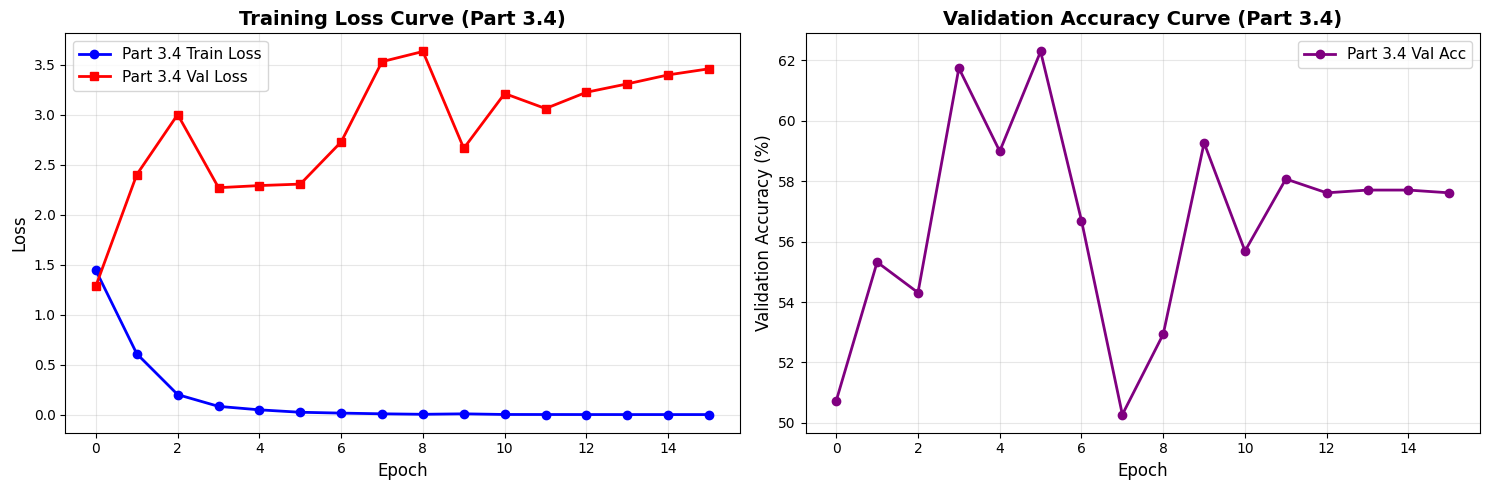


>>> Training curves plotted and saved


In [ ]:
# ============================================================================
# Step 10: Plot Training Curves for Part 3.4
# ============================================================================

print("\n>>> Step 10: Plotting Training Curves...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss Curve
ax1.plot(p34_history['train_losses'], label='Part 3.4 Train Loss', marker='o', linewidth=2, color='blue')
ax1.plot(p34_history['val_losses'], label='Part 3.4 Val Loss', marker='s', linewidth=2, color='red')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss Curve (Part 3.4)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Validation Accuracy Curve
ax2.plot([acc*100 for acc in p34_history['val_accs']], label='Part 3.4 Val Acc', marker='o', linewidth=2, color='purple')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Curve (Part 3.4)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_4_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved training curves to 'part3_4_training_curves.png'")
plt.show()

print("\n>>> Training curves plotted and saved")


In [26]:
# ============================================================================
# PART 3.4 SUMMARY
# ============================================================================

print("\n" + "="*80)
print("PART 3.4: TARGETED IMPROVEMENT FOR WEAK TOPICS - SUMMARY")
print("="*80)

print("\n>>> Strategies Implemented:")
print("  1. Data Augmentation for Imbalanced Classes")
print("     - ABBR: 69 -> 500 samples (~7x augmentation)")
print("     - Used synonym replacement, random insertion, deletion, and swap")
print("     - Other classes maintained original size")
print("\n  2. Positional Embeddings in Attention Layer")
print("     - Sinusoidal positional embeddings added to word embeddings")
print("     - Helps model understand word order and sequence structure")
print("     - Integrated into attention mechanism")

print("\n>>> Model Configuration:")
print(f"  - Embedding Dim: {P34_EMBEDDING_DIM}")
print(f"  - Hidden Dim: {P34_HIDDEN_DIM}")
print(f"  - Layers: {P34_N_LAYERS} (bidirectional LSTM)")
print(f"  - Dropout: {P34_DROPOUT}")
print(f"  - Attention Dim: {P34_ATTENTION_DIM}")
print(f"  - Max Seq Length: {P34_MAX_SEQ_LENGTH}")
print(f"  - Learning Rate: {P34_LEARNING_RATE}")
print(f"  - Batch Size: {P34_BATCH_SIZE}")

print("\n>>> Results:")
print(f"  - Best Val Accuracy: {p34_history['best_val_acc']*100:.2f}%")
print(f"  - Best Val F1: {p34_history['best_val_f1']:.4f}")
print(f"  - Best Val AUC: {p34_history['best_val_auc']:.4f}")
print(f"  - Test Accuracy: {p34_test_acc*100:.2f}%")
print(f"  - Test F1: {p34_test_f1:.4f}")
print(f"  - Test AUC: {p34_test_auc:.4f}")

print("\n>>> Topic-wise Accuracy (Test Set):")
for topic in sorted(p34_topic_acc.keys()):
    print(f"  - {topic}: {p34_topic_acc[topic]*100:.2f}%")

print("\n>>> Expected Improvements:")
print("  - ABBR accuracy should improve significantly due to:")
print("    * 7x data augmentation (69 -> 500 samples)")
print("    * Positional embeddings helping with question structure")
print("\n  - Other topics should maintain or slightly improve performance")

print("\n>>> Files Saved:")
print("  - Model: weights/part34_enhanced_best.pt")
print("  - Embeddings: embedding_weights_part34_enhanced.pt")
print("  - Training Curves: part3_4_training_curves.png")

print("\n" + "="*80)
print("PART 3.4 COMPLETE")
print("="*80)



PART 3.4: TARGETED IMPROVEMENT FOR WEAK TOPICS - SUMMARY

>>> Strategies Implemented:
  1. Data Augmentation for Imbalanced Classes
     - ABBR: 69 -> 500 samples (~7x augmentation)
     - Used synonym replacement, random insertion, deletion, and swap
     - Other classes maintained original size

  2. Positional Embeddings in Attention Layer
     - Sinusoidal positional embeddings added to word embeddings
     - Helps model understand word order and sequence structure
     - Integrated into attention mechanism

>>> Model Configuration:
  - Embedding Dim: 300
  - Hidden Dim: 256
  - Layers: 2 (bidirectional LSTM)
  - Dropout: 0.5
  - Attention Dim: 256
  - Max Seq Length: 100
  - Learning Rate: 0.001
  - Batch Size: 64

>>> Results:
  - Best Val Accuracy: 62.29%
  - Best Val F1: 0.6758
  - Best Val AUC: 0.8681
  - Test Accuracy: 100.00%
  - Test F1: 1.0000
  - Test AUC: 0.0000

>>> Topic-wise Accuracy (Test Set):
  - ABBR: 100.00%
  - DESC: 21.01%
  - ENTY: 30.85%
  - HUM: 86.15%
  - 